In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from utils.help_func import create_path, print_var_detail
# Ordered label list used in your training
detect_sequence = ['T1_T1flair', 'T2', 'T2flair_flair', 'PD', 'T2star_hemo', 'T2star_swi', 'DTI_DWI']

class MRISequenceDataset(Dataset):
    def __init__(self, root_dir, transform=None, dtype=torch.float32):
        """
        Args:
            root_dir: Path to the root directory (e.g. ./finetune_data/sequence_detection/train)
            transform: Optional transform (not needed if .npy files are already [3, 224, 224] and normalized)
            dtype: Tensor type (e.g., torch.float32 or torch.float16)
        """
        self.samples = []
        self.label_map = {name: i for i, name in enumerate(detect_sequence)}
        self.transform = transform
        self.dtype = dtype

        for label_name in detect_sequence:
            class_dir = os.path.join(root_dir, label_name)
            if not os.path.isdir(class_dir):
                continue
            for fname in os.listdir(class_dir):
                if fname.endswith(".npy"):
                    self.samples.append((os.path.join(class_dir, fname), self.label_map[label_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label_idx = self.samples[idx]

        # Load image (3, 224, 224), normalized [0,1]
        img = np.load(img_path).astype(np.float32)
        img_tensor = torch.tensor(img, dtype=self.dtype)

        # One-hot encode label
        label_tensor = torch.zeros(len(detect_sequence), dtype=torch.float32)
        label_tensor[label_idx] = 1.0

        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, label_tensor


In [2]:
from torch.utils.data import DataLoader

def get_dataloaders(train_root, test_root, batch_size=64, num_workers=4, dtype=torch.float32):
    train_dataset = MRISequenceDataset(train_root, dtype=dtype)
    test_dataset = MRISequenceDataset(test_root, dtype=dtype)

    loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True)
    loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                             num_workers=num_workers, pin_memory=True)

    return loader_train, loader_test


In [7]:
train_root = './finetune_data/sequence_detection/train'
test_root = './finetune_data/sequence_detection/test'
batch_size = 256
dataloader_train, dataloader_val = get_dataloaders(train_root, test_root, batch_size=batch_size, num_workers=0, dtype=torch.float16)


In [13]:
images, labels = next(iter(dataloader_train))
image_tensor = images
one_hot_tensor = labels
label_indices = torch.argmax(one_hot_tensor, dim=1)

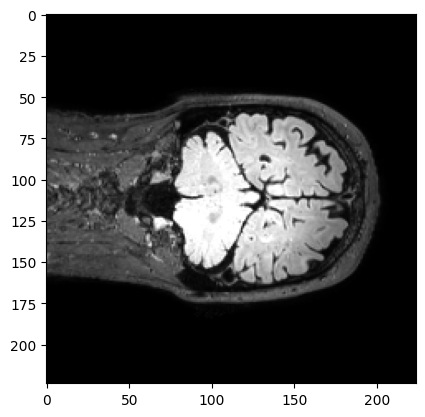

In [14]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(image_tensor[0].to(dtype=torch.float32).permute(1, 2, 0), cmap='gray')
plt.show()

In [11]:
from sequence_detection.models_mae_finetune import MaskedAutoencoderViTClassify
from functools import partial
import torch
import torch.nn as nn
model = MaskedAutoencoderViTClassify(
        patch_size=16, embed_dim=768, depth=12, num_heads=12,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), num_classes=len(detect_sequence) + 1, mode='cls')

pretrain_path = './saved_models/mae_vit_base_patch16_pretrain_test0.75_E30/model_E30.pt'

missing, unexpected = model.load_state_dict(torch.load(pretrain_path)['model_state_dict'], strict=False)  # strict=False ignores unmatched keys
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)
print(sum(p.numel() for p in model.parameters()))
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
def get_model_size_in_mb(model):
    """
    Get the size (in MB) of a model's parameters and buffers on GPU memory.
    """
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()

    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_in_bytes = param_size + buffer_size
    size_in_megabytes = size_in_bytes / (1024 ** 2)  # bytes to MB
    return size_in_megabytes

def get_trainable_model_size_in_mb(model):
    """
    Returns the total GPU memory (in MB) used by trainable parameters of a model.
    """
    total_bytes = sum(
        p.nelement() * p.element_size()
        for p in model.parameters()
        if p.requires_grad
    )
    return total_bytes / (1024 ** 2)



model = model.to('cuda')
def freeze_mae_encoder_and_decoder(model):
    for name, param in model.named_parameters():
        if name.startswith("patch_embed") or name.startswith("blocks") or \
           name.startswith("norm") or name in ["cls_token", "pos_embed"] or \
           name.startswith("decoder") or name == "mask_token":
            param.requires_grad = False
freeze_mae_encoder_and_decoder(model)
model_size_mb = get_trainable_model_size_in_mb(model)
print(f"Model size on GPU: {model_size_mb:.2f} MB")

Missing keys: ['cls_head.weight', 'cls_head.bias']
Unexpected keys: []
111913992
111661832
Model size on GPU: 0.02 MB


In [15]:
from sequence_detection.train_mae_finetune import Trainer

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)
loss_fn = torch.nn.CrossEntropyLoss()
freeze_mae_encoder = True
TRAIN_EPOCHS = 1000
cls_strategy = 'cls_token'
if freeze_mae_encoder:
    path_save = "./finetune_models/sequence_detection/max_train_len_freeze_mae_encoder_" + cls_strategy + "_e" + str(TRAIN_EPOCHS) + '/'
else:
    path_save = "./finetune_models/sequence_detection/max_train_len_nofreeze_mae_encoder_" + cls_strategy + "_e" + str(TRAIN_EPOCHS) + '/'

create_path(path_save)
trainer = Trainer(
    loader_train=dataloader_train,
    loader_test=dataloader_val,
    my_model=model,
    my_loss=torch.nn.CrossEntropyLoss(),
    optimizer=optimizer,
    RESUME_EPOCH=0,
    PATH_MODEL=path_save,
    device=device,
    cls_strategy = cls_strategy,  # or 'cls_token', 'mean_patch', 'mean_all', 'attn_pool',
    freeze_mae_encoder=freeze_mae_encoder,
    freeze_mae_encoder_decoder=freeze_mae_encoder, # free encoder and decoder for classification to get actual trainable params printed out
)

trainer.train(epochs=TRAIN_EPOCHS, show_step=500, show_test=True)


D:\Mengyu_Li\General_Dataloader_Git_V1\sequence_detection\train_mae_finetune.py:3: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


device: cuda:0
Path already exists.
111913992
6152


LOSS:   0%|          | 0/1000 [00:00<?, ?it/s]

images_input is a  <class 'torch.Tensor'> with shape torch.Size([256, 3, 224, 224]) max:  tensor(1., device='cuda:0', dtype=torch.float16) min:  tensor(0., device='cuda:0', dtype=torch.float16)
image_label (as indices) is a  <class 'torch.Tensor'> with shape torch.Size([256]) max:  tensor(6, device='cuda:0') min:  tensor(0, device='cuda:0')
trained batches: 0
time: 1.5545709133148193 sec
trained batches: 1
time: 0.4200155735015869 sec


EPOCH [1/1000] || AVG LOSS: 2.069879:   0%|          | 0/1000 [00:02<?, ?it/s]

trained batches: 2
time: 0.3160111904144287 sec
*** EPOCH 1 || AVG LOSS: 2.069879


EPOCH [1/1000] || AVG LOSS: 2.069879:   0%|          | 1/1000 [00:02<42:38,  2.56s/it]

MODEL CKPT SAVED.


EPOCH [500/1000] || AVG LOSS: 0.418751:  50%|████▉     | 499/1000 [05:53<05:49,  1.43it/s]

*** EPOCH 500 || AVG LOSS: 0.418751


EPOCH [500/1000] || AVG LOSS: 0.418751:  50%|█████     | 500/1000 [05:53<06:29,  1.28it/s]

MODEL CKPT SAVED.


EPOCH [1000/1000] || AVG LOSS: 0.160558: 100%|█████████▉| 999/1000 [11:55<00:00,  1.36it/s]

*** EPOCH 1000 || AVG LOSS: 0.160558


EPOCH [1000/1000] || AVG LOSS: 0.160558: 100%|██████████| 1000/1000 [11:55<00:00,  1.40it/s]


MODEL CKPT SAVED.


Testing: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s]

### TEST LOSS: 0.151276 || Accuracy: 99.74% || Correct: 3491 / 3500
----------------------------------------------------------------------
Per-class accuracy:
Class 0: 99.40% (497 / 500)
Class 1: 99.60% (498 / 500)
Class 2: 100.00% (500 / 500)
Class 3: 99.60% (498 / 500)
Class 4: 99.80% (499 / 500)
Class 5: 100.00% (500 / 500)
Class 6: 99.80% (499 / 500)
Class 7: 0.00% (0 / 0)


MaskedAutoencoderViTClassify(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (decoder_embed): Linear(in_features=768, out_features=51